In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

In [1031]:
# Function that resamples trajectory to have M evenly spaced points
def resample_trajectory(trajectory, M):
    N = len(trajectory)
    seg_len = path_length(trajectory) / M
    g = {0: trajectory[0]}
    i = 0
    k = 1
    alpha = 0.0
    beta = seg_len
    
    while (i < N) and (k < M):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        d = ((x1 - x0)**2 + (y1 - y0)**2)**0.5
        
        while (beta <= alpha + d) and (k < M):
            xk = x0 + (beta - alpha) * (x1 - x0) / d
            yk = y0 + (beta - alpha) * (y1 - y0) / d
            g[k] = (xk, yk)
            k += 1
            beta += seg_len
            
        alpha += d
        i += 1
        
    return g
    
# Function that computes the total length of the trajectory
def path_length(trajectory):
    N = len(trajectory)
    length = 0.0
    for i in range(0,N):
        x0, y0 = trajectory[i]
        x1, y1 = trajectory[(i+1) % N]
        length += ((x1 - x0)**2 + (y1 - y0)**2)**0.5
    return length

# Function that computes the Fourier Descriptor Transform
def fourier_descriptor_transform(g):
    N = len(g)
    z = np.array([complex(x, y) for x, y in g.values()])
    Z = np.fft.fft(z) / N
    return Z

# Function that computes the Inverse Fourier Descriptor Transform
def inverse_fourier_descriptor_transform(Z):
    N = len(Z)
    z = np.fft.ifft(Z * N)
    g_reconstructed = {m: (z[m].real, z[m].imag) for m in range(N)}
    return g_reconstructed

def get_descriptors(filepath, M=100):
    df = pd.read_csv(filepath)
    df.drop_duplicates(subset=['x', 'y'], keep='first', inplace=True)
    df['x'] = df['x'] - df['x'].iloc[0]
    df['y'] = df['y'] - df['y'].iloc[0]

    g = resample_trajectory(list(zip(df['x'], df['y'])), M)
    Z = fourier_descriptor_transform(g)
    return Z

def archimedas_spiral(theta_range, a0, granularity=500):
    theta = np.linspace(theta_range[0], theta_range[1], granularity)
    arch_x = a0*theta*np.cos(theta)
    arch_y = a0*theta*np.sin(theta)
    
    return (arch_x,arch_y)

def archimedas_descriptor(theta_range, a0, granularity=500):
    arch = archimedas_spiral(theta_range, a0, granularity)
    
    arch_traj = resample_trajectory([(x,y) for x,y in zip(arch[0],arch[1])],M)
    Z_archimedes = fourier_descriptor_transform(arch_traj)
    
    return Z_archimedes

def remove_end_line(x, y, tol=1e-6):
    x = np.asarray(x)
    y = np.asarray(y)
    
    if len(x) < 3:
        return x, y
    
    last_point = np.array([x[-1], y[-1]])
    second_last_point = np.array([x[-2], y[-2]])
    line_vec = last_point - second_last_point
    
    for i in range(len(x) - 2, 0, -1):
        point = np.array([x[i], y[i]])
        vec = point - second_last_point
        cross = line_vec[0] * vec[1] - line_vec[1] * vec[0]
        if abs(cross) > tol:
            return x[:i+1], y[:i+1]
    
    return x, y

def plot_segmented_spiral(
    gen_theta,
    gen_r,
    num_segments=10,
    num_points=500,
    colors=None,
    figsize=(12, 6),
    plot_title=None,
    axes=None
):
    """
    Generates and plots a spiral with segments of different colors.

    Parameters:
    - num_segments (int): The number of colored segments to divide the plot into.
    - num_points (int): The total number of points to generate for the spiral. Default is 500.
    - theta_end (int): The number of full rotations (2*pi) for the spiral. Default is 10.
    - noise_range (tuple): A tuple (min, max) for adding random noise to the radius.
                           Default is (-10, 10).
    - colors (list or None): A list of colors to use for the segments. If None,
                             Matplotlib's default color cycle will be used.
    - figsize (tuple): A tuple (width, height) for the figure size. Default is (12, 6).
    - plot_title (str or None): Title for the entire plot. If None, 'Spiral Generation with {num_segments} Segments' is set.
    - axes (tuple or None): A tuple of Matplotlib axes to plot on. If None, new axes will be created.
    """
    
    points_per_segment = num_points // num_segments
    segments_theta = [
        gen_theta[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    segments_r = [
        gen_r[i * points_per_segment : (i + 1) * points_per_segment + 1]
        for i in range(num_segments)
    ]
    
    # Use default colors if none are provided
    if colors is None:
        cmap = plt.colormaps['tab20']
        colors = [cmap(i) for i in range(num_segments)]
    colors = [colors[i % len(colors)] for i in range(num_segments)]

    # 3. Create the plots
    if axes is None:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw={'wspace': 0.2})
        ax2 = fig.add_subplot(1, 2, 2, projection='polar')
    else:
        ax1, ax2 = axes

    # Cartesian subplot (Radius vs Theta)
    for i in range(num_segments):
        ax1.plot(np.unwrap(segments_theta[i]), segments_r[i], color=colors[i])
    
    ax1.set_title("Radius vs Theta")
    ax1.grid(True)
    
    
    theta_end = int(gen_theta[-1] / np.pi)
    tick_positions = np.linspace(0, theta_end * np.pi, theta_end + 1)
    tick_labels = [f'{i}π' for i in range(theta_end + 1)]
    
    ax1.set_xticks(tick_positions, tick_labels)
    ax1.set_xlabel("Theta (radians)")
    ax1.set_ylabel("Radius")

    # Polar subplot (Spiral)
    for i in range(num_segments):
        ax2.plot(segments_theta[i], segments_r[i], color=colors[i])
    
    ax2.set_title("Generated spiral")
    ax2.grid(False)
    ax2.axis('off')
    
    if plot_title:
        plt.suptitle(plot_title)
    else:
        plt.suptitle(f"Spiral Generation with {num_segments} Segments")
    
    if axes is None:
        plt.show()
    else: 
        return ax1, ax2

### Testing Gaussian smoothing

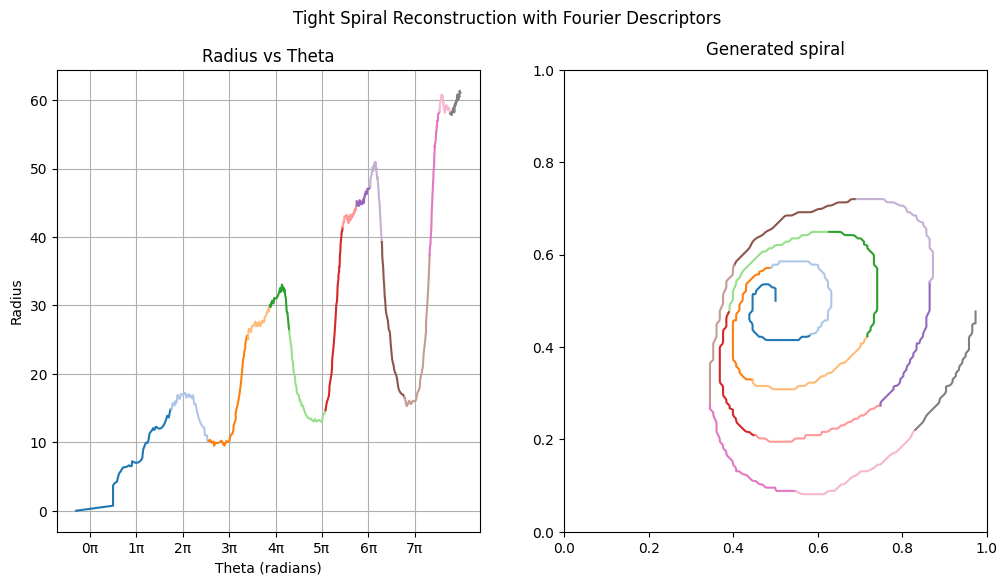

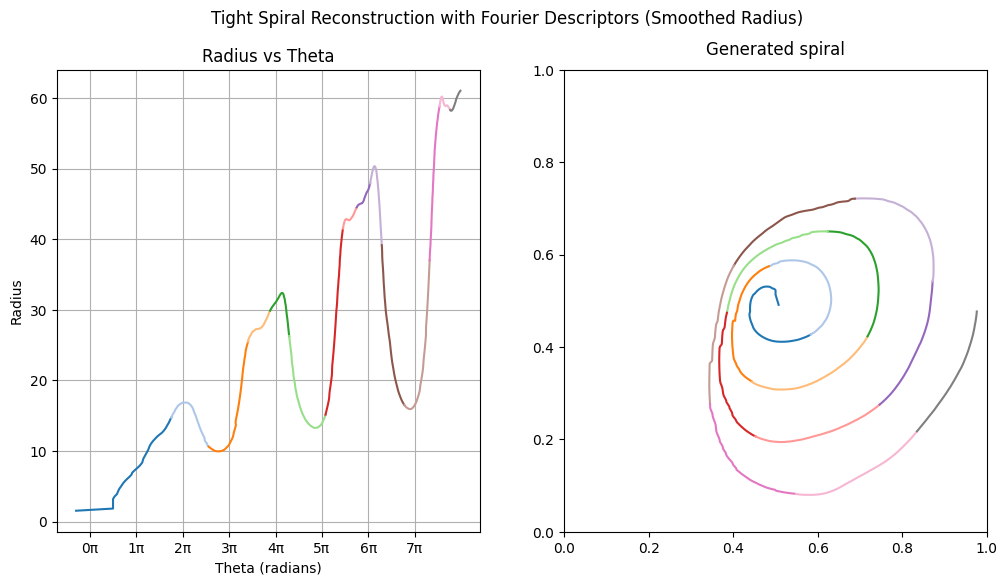

In [1034]:
directory = "drawings/nice_samples/"
filename = "spirala_tight"
filepath = directory + filename + ".csv"

descriptors = get_descriptors(filepath, M=1000)
g_recon = np.array(list(inverse_fourier_descriptor_transform(descriptors).values()))
sp_x, sp_y = remove_end_line(g_recon[:,0], g_recon[:,1])
sp_y = -sp_y  # Invert y-axis if necessary
sp_r = np.sqrt(sp_x**2 + sp_y**2)
sp_theta = np.arctan2(sp_y, sp_x)
sp_theta = np.unwrap(sp_theta)

parts = [p.capitalize() for p in filename.split("_")]
plot_title = f"{' '.join(parts[1:])} Spiral Reconstruction with Fourier Descriptors"

plot_segmented_spiral(
    gen_theta=sp_theta,
    gen_r=sp_r,
    num_segments=15,
    num_points=len(sp_theta),
    colors=None,
    figsize=(12, 6),
    plot_title=plot_title
)

smooth_r = gaussian_filter(sp_r, sigma=10.0, mode='nearest', radius=10)

plot_segmented_spiral(
    gen_theta=sp_theta,
    gen_r=smooth_r,
    num_segments=15,
    num_points=len(sp_theta),
    colors=None,
    figsize=(12, 6),
    plot_title=plot_title+" (Smoothed Radius)"
)

### Generating Archimedes spirals

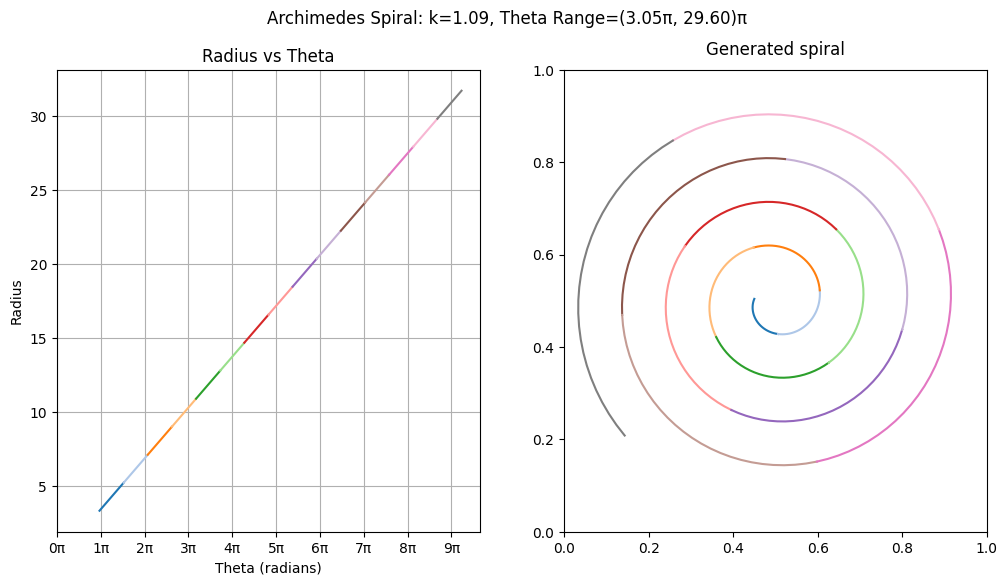

In [117]:
## PARAMETERS
steps_per_rotation = 100
max_theta_range = (6*np.pi, 12*np.pi)
max_theta_offset = np.pi
k_range = (0.5, 2.0)

## TESTING ARCHIMEDES SPIRAL GENERATION
test_theta_lb = np.random.uniform(0, max_theta_offset)
test_theta_ub = np.random.uniform(max_theta_range[0], max_theta_range[1])
test_theta = np.linspace(test_theta_lb, test_theta_ub, int(steps_per_rotation * ((test_theta_ub-test_theta_lb) // (2 * np.pi))))
test_k = np.random.uniform(k_range[0], k_range[1])
test_r = test_k * test_theta

plot_segmented_spiral(
    gen_theta=test_theta,
    gen_r=test_r,
    num_segments=15,
    num_points=len(test_theta),
    colors=None,
    figsize=(12, 6),
    plot_title=f"Archimedes Spiral: k={test_k:.2f}, Theta Range=({test_theta_lb:.2f}π, {test_theta_ub:.2f})π"
)

**Generation**

In [102]:
N_SAMPLES = 1000
directory = "syn_data/archimedes/"
name_template = "archimedes_spiral_{}.csv"

for i in range(N_SAMPLES):
    theta_lb = np.random.uniform(0, max_theta_offset)
    theta_ub = np.random.uniform(max_theta_range[0], max_theta_range[1])
    theta = np.linspace(theta_lb, theta_ub, int(steps_per_rotation * ((theta_ub-theta_lb) // (2 * np.pi))))
    k = np.random.uniform(k_range[0], k_range[1])
    r = k * theta
    
    pd.DataFrame({'theta': theta, 'r': r}).to_csv(directory + name_template.format(i), index=False)

### Generating tight Archimedes spirals

In [3]:
def apply_local_shaping(r_data, theta_data, local_minimas_theta, local_minimas_r, 
                        local_maximas_theta, local_maximas_r, tightness_width, flat_precentage):
    """
    Applies local shaping (tightening for minimas, loosening for maximas) to the radial data.

    Args:
        r_data (np.ndarray): The radial data array to be modified.
        theta_data (np.ndarray): The corresponding angular data array.
        local_minimas_theta (np.ndarray): Angles of local minimas.
        local_minimas_r (np.ndarray): Radii of local minimas.
        local_maximas_theta (np.ndarray): Angles of local maximas.
        local_maximas_r (np.ndarray): Radii of local maximas.
        tightness_width (float): The total angular width of the shaping window.
        flat_precentage (float): The percentage of the width that will be flat (0 to 1).

    Returns:
        np.ndarray: The modified radial data array.
    """
    
    # Create a copy of the radial data to modify
    r_shaped = r_data.copy()
    
    HALF_FLAT_WIDTH = (tightness_width * flat_precentage) / 2
    
    # Combine minimas and maximas into a list of tasks
    # Each task is (theta_list, r_list, application_function)
    tasks = [
        (local_minimas_theta, local_minimas_r, np.minimum),  # Minimas: Use np.minimum to pull down
        (local_maximas_theta, local_maximas_r, np.maximum)   # Maximas: Use np.maximum to push up
    ]
    
    # Process both minimas and maximas in a single loop structure
    for lt_thetas, lt_rs, application_func in tasks:
        
        if len(lt_thetas) == 0:
            continue

        for i in range(len(lt_thetas)):
            lt_theta = lt_thetas[i]
            lt_r = lt_rs[i]
            
            # 1. Define the full angular window (W)
            full_start_angle = lt_theta - tightness_width / 2
            full_end_angle = lt_theta + tightness_width / 2
            
            # 2. Define the FLAT region boundaries (F)
            flat_start_angle = lt_theta - HALF_FLAT_WIDTH
            flat_end_angle = lt_theta + HALF_FLAT_WIDTH
            
            # 3. Get the radius at the edges of the full window from the CURRENT r_shaped array
            # These are the points the ramps connect *to*.
            # Use theta_data for the x-axis and r_shaped for the y-axis (the current curve)
            r_at_start = np.interp(full_start_angle, theta_data, r_shaped)
            r_at_end = np.interp(full_end_angle, theta_data, r_shaped)
            
            # 4. Initialize the target radius array for the entire window
            mask_full = (theta_data >= full_start_angle) & (theta_data <= full_end_angle)
            theta_segment = theta_data[mask_full]
            r_target_segment = np.empty_like(theta_segment)
            
            # --- A. Flat Central Region ---
            mask_flat = (theta_segment >= flat_start_angle) & (theta_segment <= flat_end_angle)
            r_target_segment[mask_flat] = lt_r
            
            # --- B. Left Ramp Region ---
            mask_left = theta_segment < flat_start_angle
            theta_left = theta_segment[mask_left]
            
            # Ramp connects r_at_start (at full_start_angle) to lt_r (at flat_start_angle)
            denominator_left = flat_start_angle - full_start_angle
            
            if denominator_left > 1e-9: 
                # Formula: r = r_start + (r_end - r_start) * ( (theta - theta_start) / (theta_end - theta_start) )
                r_target_left = r_at_start + (lt_r - r_at_start) * (
                    (theta_left - full_start_angle) / denominator_left
                )
            else: 
                r_target_left = np.full_like(theta_left, lt_r)

            r_target_segment[mask_left] = r_target_left
            
            # --- C. Right Ramp Region ---
            mask_right = theta_segment > flat_end_angle
            theta_right = theta_segment[mask_right]

            # Ramp connects lt_r (at flat_end_angle) to r_at_end (at full_end_angle)
            denominator_right = full_end_angle - flat_end_angle
            
            if denominator_right > 1e-9: 
                # Formula: r = r_start + (r_end - r_start) * ( (theta - theta_start) / (theta_end - theta_start) )
                r_target_right = lt_r + (r_at_end - lt_r) * (
                    (theta_right - flat_end_angle) / denominator_right
                )
            else: 
                r_target_right = np.full_like(theta_right, lt_r)
                
            r_target_segment[mask_right] = r_target_right
            
            # 5. Apply the shaping: use the stored application_func (np.minimum for minimas, np.maximum for maximas)
            r_shaped[mask_full] = application_func(r_shaped[mask_full], r_target_segment)
            
    return r_shaped

In [4]:
## PARAMETERS
steps_per_rotation = 100
max_theta_range = (6*np.pi, 12*np.pi)
max_theta_offset = np.pi
k_range = (0.5, 2.0)

tightness_angle_range = (0, 2*np.pi)
n_ratio_range = (0.03, 0.09) # Ratio of n parameter for linear equation in terms of max radius
tightness_k_range = (0.1, 1.3)
tightness_width_ratio_range = (0.14, 0.2) # Ratio of width of tightness to max radius
max_k2k_ratio = 0.55  # Max ratio of tightness_k to original k
FLAT_PERCENTAGE = 0.3

## TESTING TIGHT ARCHIMEDES SPIRAL GENERATION
# Basic spiral parameters
theta_lb = np.random.uniform(0, max_theta_offset)
theta_ub = np.random.uniform(max_theta_range[0], max_theta_range[1])
theta = np.linspace(theta_lb, theta_ub, int(steps_per_rotation * ((theta_ub-theta_lb) // (2 * np.pi))))
k = np.random.uniform(k_range[0], k_range[1])
r = k * theta

# Tightening parameters
tightness_angle = np.random.uniform(tightness_angle_range[0], tightness_angle_range[1])
n_ratio = np.random.uniform(n_ratio_range[0], n_ratio_range[1])
max_r = np.max(r)
tightness_k = np.random.uniform(tightness_k_range[0], np.min([tightness_k_range[1], max_k2k_ratio*k]))
tightness_width = np.random.uniform(tightness_width_ratio_range[0], tightness_width_ratio_range[1]) * max_r


local_minimas_theta = []
local_minimas_r = []
minima_theta = tightness_angle
while minima_theta < theta_ub + 2*np.pi:
    local_minimas_theta.append(minima_theta)
    local_minimas_r.append(tightness_k * minima_theta + n_ratio * max_r)
    minima_theta += 2*np.pi
local_minimas_theta = np.array(local_minimas_theta)
local_minimas_r = np.array(local_minimas_r)


r_tightened = r.copy()
r_tightened = apply_local_shaping(r_tightened, theta, local_minimas_theta, local_minimas_r, [], [], tightness_width, FLAT_PERCENTAGE)
r_tightened = gaussian_filter(r_tightened, sigma=10.0, mode='nearest', radius=6)
    
plot_segmented_spiral(
    gen_theta=theta,
    gen_r=r_tightened,
    num_segments=15,
    num_points=len(theta),
    colors=None,
    figsize=(12, 6),
    plot_title=f"Tightened Archimedes Spiral: n_ratio={n_ratio:.3f}, tightness_k={tightness_k:.2f}, tightness_width={tightness_width:.2f}"
)

AttributeError: 'float' object has no attribute 'copy'

**Generation**

In [1009]:
N_SAMPLES = 1000
directory = "syn_data/tight/"
name_template = "tight_spiral_{}.csv"

for i in range(N_SAMPLES):
    # Basic spiral parameters
    theta_lb = np.random.uniform(0, max_theta_offset)
    theta_ub = np.random.uniform(max_theta_range[0], max_theta_range[1])
    theta = np.linspace(theta_lb, theta_ub, int(steps_per_rotation * ((theta_ub-theta_lb) // (2 * np.pi))))
    k = np.random.uniform(k_range[0], k_range[1])
    r = k * theta

    # Tightening parameters
    tightness_angle = np.random.uniform(tightness_angle_range[0], tightness_angle_range[1])
    n_ratio = np.random.uniform(n_ratio_range[0], n_ratio_range[1])
    max_r = np.max(r)
    tightness_k = np.random.uniform(tightness_k_range[0], np.min([tightness_k_range[1], max_k2k_ratio*k]))
    tightness_width = np.random.uniform(tightness_width_ratio_range[0], tightness_width_ratio_range[1]) * max_r


    local_minimas_theta = []
    local_minimas_r = []
    minima_theta = tightness_angle
    while minima_theta < theta_ub + 2*np.pi:
        local_minimas_theta.append(minima_theta)
        local_minimas_r.append(tightness_k * minima_theta + n_ratio * max_r)
        minima_theta += 2*np.pi
    local_minimas_theta = np.array(local_minimas_theta)
    local_minimas_r = np.array(local_minimas_r)


    r_tightened = r.copy()
    r_tightened = apply_local_shaping(r_tightened, theta, local_minimas_theta, local_minimas_r, [], [], tightness_width, FLAT_PERCENTAGE)
    r_tightened = gaussian_filter(r_tightened, sigma=10.0, mode='nearest', radius=6)
    
    pd.DataFrame({'theta': theta, 'r': r_tightened}).to_csv(directory + name_template.format(i), index=False)

### Generating partially flat Archimedes spirals

**Single flat region**

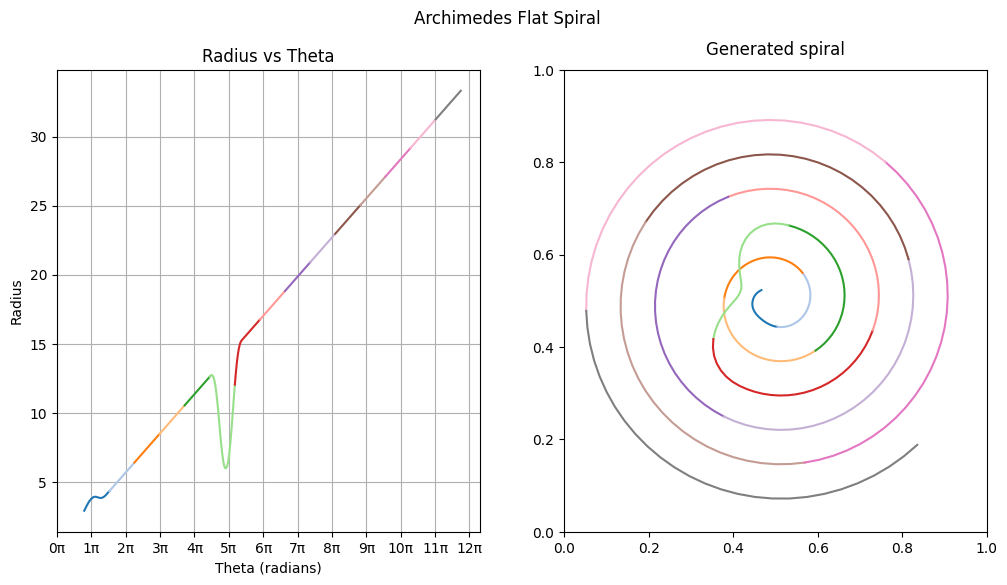

In [649]:
## PARAMETERS
steps_per_rotation = 100
max_theta_range = (6*np.pi, 12*np.pi)
max_theta_offset = np.pi
k_range = (0.5, 2.0)

## TESTING FLAT ARCHIMEDES SPIRAL GENERATION
theta_lb = np.random.uniform(0, max_theta_offset)
theta_ub = np.random.uniform(max_theta_range[0], max_theta_range[1])
theta = np.linspace(theta_lb, max_theta_range[1], int(steps_per_rotation * ((theta_ub-theta_lb) // (2 * np.pi))))
k = np.random.uniform(k_range[0], k_range[1])
r = k * theta

flat_angle = np.pi
flat_width = 1.3
flat_depth = k * flat_angle * 1.55

flat_angle2 = 15.467966476149646
flat_width2 = 1.264583601088927
flat_depth2 = 0.5284721329703577

r_flat = r.copy()
r_flat = apply_local_shaping(r_flat, theta, np.array([flat_angle2]), np.array([flat_depth2]), np.array([flat_angle]), np.array([flat_depth]), flat_width, 0.2)
r_flat = gaussian_filter(r_flat, sigma=7.0, mode='nearest', radius=8)

plot_segmented_spiral(
    gen_theta=theta,
    gen_r=r_flat,
    num_segments=15,
    num_points=len(theta),
    colors=None,
    figsize=(12, 6),
    plot_title=f"Archimedes Flat Spiral"
)

**Muiltiple flat regions**

In [753]:
def check_for_intr_improved(theta, r):
    """
    Checks for self-intersection in a polar curve (r, theta) over a 2*pi rotation.
    Self-intersection occurs if r(theta + 2*pi) < r(theta).
    
    Args:
        theta (np.ndarray): Array of angles (must span at least 2*pi).
        r (np.ndarray): Array of radii.

    Returns:
        bool: True if self-intersection is detected, False otherwise.
    """
    
    # 1. Ensure theta is sorted (required for np.interp)
    # This is generally true for spiral generation, but good practice.
    sort_indices = np.argsort(theta)
    theta_sorted = theta[sort_indices]
    r_sorted = r[sort_indices]

    # 2. Iterate only over the angles where theta + 2*pi is still within the domain
    # This optimization avoids unnecessary checks and handles bounds better.
    theta_limit = theta_sorted[-1] - 2 * np.pi
    
    # Use a mask to get the angles in the current domain (theta) that are also in the 
    # range [theta_start, theta_end - 2*pi]
    mask = theta_sorted <= theta_limit
    theta_current = theta_sorted[mask]
    r_current = r_sorted[mask]

    # 3. Use NumPy's highly efficient np.interp to find r(theta + 2*pi)
    # The 'theta_current + 2 * np.pi' array serves as the x-coordinates to interpolate.
    theta_plus_2pi = theta_current + 2 * np.pi
    
    # r_plus_2pi is the interpolated radius at the next rotation
    r_plus_2pi = np.interp(theta_plus_2pi, theta_sorted, r_sorted)

    # 4. Check the condition for self-intersection across all relevant points
    # Intersection occurs if the radius is decreasing too fast: r(theta + 2pi) < r(theta)
    if np.any(r_plus_2pi < r_current):
        return True
    
    return False

Checking for intrusions: False


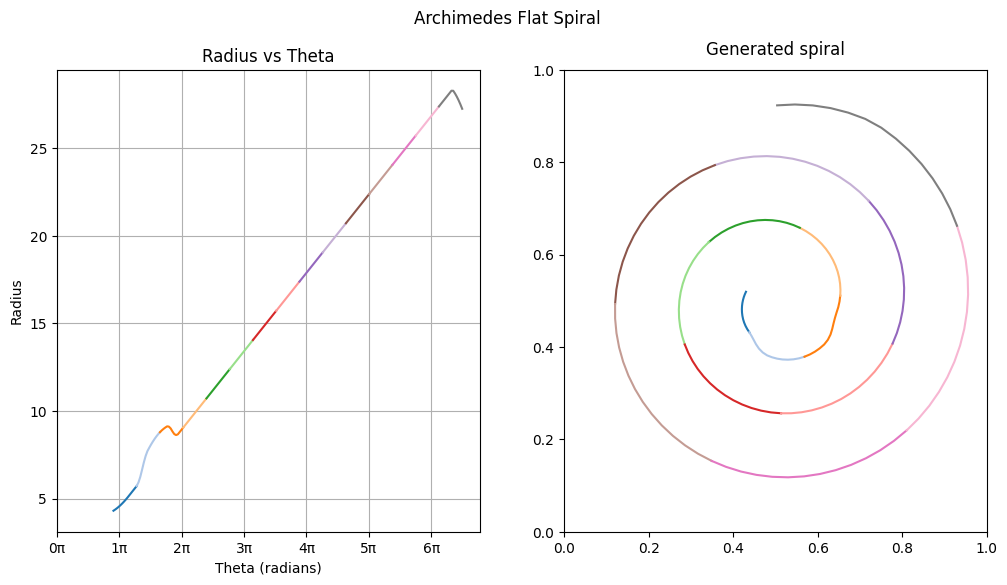

In [806]:
## PARAMETERS
steps_per_rotation = 100
max_theta_range = (6*np.pi, 12*np.pi)
max_theta_offset = np.pi
k_range = (0.5, 2.0)

max_in_flats_per_rotation = 2
max_out_flats_per_rotation = 1
max_flats_per_rotation = 1

in_flat_angle_range = (np.pi, 11*np.pi)
out_flat_angle_range = (3*np.pi/2, 11*np.pi)

in_flat_width_line_k = (0.7 - 1.6) / (11*np.pi - np.pi)
in_flat_width_line_n = 1.5 - in_flat_width_line_k * np.pi
in_flat_depth_line_k = (0.6 - 0.52) / (11*np.pi - np.pi)
in_flat_depth_line_n = 0.52 - in_flat_depth_line_k * np.pi

out_flat_width_line_k = (1.3 - 0.6) / (11*np.pi - 3*np.pi/2)
out_flat_width_line_n = 0.6 - out_flat_width_line_k * (3*np.pi/2)
out_flat_depth_line_k = (1.55 - 1.75) / (11*np.pi - 3*np.pi/2)
out_flat_depth_line_n = 1.75 - out_flat_depth_line_k * (3*np.pi/2)

FLAT_PERCENTAGE = 0.2

## TESTING FLAT ARCHIMEDES SPIRAL GENERATION
theta_lb = np.random.uniform(0, max_theta_offset)
theta_ub = np.random.uniform(max_theta_range[0], max_theta_range[1])
theta = np.linspace(theta_lb, theta_ub, int(steps_per_rotation * ((theta_ub-theta_lb) // (2 * np.pi))))
k = np.random.uniform(k_range[0], k_range[1])
r = k * theta

num_in_flats = np.random.randint(1, int(max_in_flats_per_rotation*(theta_ub/(2*np.pi))) + 1)
temp_bound = int(min(max_out_flats_per_rotation*(theta_ub/(2*np.pi)) + 1, (max_flats_per_rotation*(theta_ub/(2*np.pi)) + 1 - num_in_flats)))
if temp_bound <= 0:
    num_out_flats = 0
else:
    num_out_flats = np.random.randint(0, temp_bound)
if np.random.rand() < 0.20:
    num_out_flats += 1

in_flats = []
for i in range(num_in_flats):
    flat_angle = np.random.uniform(in_flat_angle_range[0], in_flat_angle_range[1])
    flat_width = (in_flat_width_line_k * flat_angle + in_flat_width_line_n)
    flat_depth = (in_flat_depth_line_k * flat_angle + in_flat_depth_line_n)
    in_flats.append((flat_angle, flat_width, flat_depth))

out_flats = []
for i in range(num_out_flats):
    flat_angle = np.random.uniform(out_flat_angle_range[0], out_flat_angle_range[1])
    flat_width = (out_flat_width_line_k * flat_angle + out_flat_width_line_n)
    flat_depth = (out_flat_depth_line_k * flat_angle + out_flat_depth_line_n)
    out_flats.append((flat_angle, flat_width, flat_depth))
    
r_flat = r.copy()
for flat in in_flats:
    flat_angle, flat_width, flat_depth = flat
    flat_depth = flat_depth * (k * flat_angle)  # Scale depth by local radius
    r_flat = apply_local_shaping(r_flat, theta, np.array([flat_angle]), np.array([flat_depth]), np.array([]), np.array([]), flat_width, FLAT_PERCENTAGE)
    # r_flat = gaussian_filter(r_flat, sigma=7.0, mode='nearest', radius=8)
    
for flat in out_flats:
    flat_angle, flat_width, flat_depth = flat
    flat_depth = flat_depth * (k * flat_angle)  # Scale depth by local radius
    r_flat = apply_local_shaping(r_flat, theta, np.array([]), np.array([]), np.array([flat_angle]), np.array([flat_depth]), flat_width, FLAT_PERCENTAGE)
    # r_flat = gaussian_filter(r_flat, sigma=7.0, mode='nearest', radius=8)
    
r_flat = gaussian_filter(r_flat, sigma=10.0, mode='nearest', radius=8)

print("Checking for intrusions:", check_for_intr_improved(theta, r_flat))

plot_segmented_spiral(
    gen_theta=theta,
    gen_r=r_flat,
    num_segments=15,
    num_points=len(theta),
    colors=None,
    figsize=(12, 6),
    plot_title=f"Archimedes Flat Spiral"
)

**Generation**

In [811]:
N_SAMPLES = 1000
directory = "syn_data/flat/"
name_template = "flat_spiral_{}.csv"

idx = 0
while idx < N_SAMPLES:
    ## PARAMETERS
    steps_per_rotation = 100
    max_theta_range = (6*np.pi, 12*np.pi)
    max_theta_offset = np.pi
    k_range = (0.5, 2.0)

    max_in_flats_per_rotation = 2
    max_out_flats_per_rotation = 1
    max_flats_per_rotation = 1

    in_flat_angle_range = (np.pi, 11*np.pi)
    out_flat_angle_range = (3*np.pi/2, 11*np.pi)

    in_flat_width_line_k = (0.7 - 1.6) / (11*np.pi - np.pi)
    in_flat_width_line_n = 1.5 - in_flat_width_line_k * np.pi
    in_flat_depth_line_k = (0.6 - 0.52) / (11*np.pi - np.pi)
    in_flat_depth_line_n = 0.52 - in_flat_depth_line_k * np.pi

    out_flat_width_line_k = (1.3 - 0.6) / (11*np.pi - 3*np.pi/2)
    out_flat_width_line_n = 0.6 - out_flat_width_line_k * (3*np.pi/2)
    out_flat_depth_line_k = (1.55 - 1.75) / (11*np.pi - 3*np.pi/2)
    out_flat_depth_line_n = 1.75 - out_flat_depth_line_k * (3*np.pi/2)

    FLAT_PERCENTAGE = 0.2

    ## TESTING FLAT ARCHIMEDES SPIRAL GENERATION
    theta_lb = np.random.uniform(0, max_theta_offset)
    theta_ub = np.random.uniform(max_theta_range[0], max_theta_range[1])
    theta = np.linspace(theta_lb, theta_ub, int(steps_per_rotation * ((theta_ub-theta_lb) // (2 * np.pi))))
    k = np.random.uniform(k_range[0], k_range[1])
    r = k * theta

    num_in_flats = np.random.randint(1, int(max_in_flats_per_rotation*(theta_ub/(2*np.pi))) + 1)
    temp_bound = int(min(max_out_flats_per_rotation*(theta_ub/(2*np.pi)) + 1, (max_flats_per_rotation*(theta_ub/(2*np.pi)) + 1 - num_in_flats)))
    if temp_bound <= 0:
        num_out_flats = 0
    else:
        num_out_flats = np.random.randint(0, temp_bound)
    if np.random.rand() < 0.20:
        num_out_flats += 1

    in_flats = []
    for i in range(num_in_flats):
        flat_angle = np.random.uniform(in_flat_angle_range[0], in_flat_angle_range[1])
        flat_width = (in_flat_width_line_k * flat_angle + in_flat_width_line_n)
        flat_depth = (in_flat_depth_line_k * flat_angle + in_flat_depth_line_n)
        in_flats.append((flat_angle, flat_width, flat_depth))

    out_flats = []
    for i in range(num_out_flats):
        flat_angle = np.random.uniform(out_flat_angle_range[0], out_flat_angle_range[1])
        flat_width = (out_flat_width_line_k * flat_angle + out_flat_width_line_n)
        flat_depth = (out_flat_depth_line_k * flat_angle + out_flat_depth_line_n)
        out_flats.append((flat_angle, flat_width, flat_depth))
        
    r_flat = r.copy()
    for flat in in_flats:
        flat_angle, flat_width, flat_depth = flat
        flat_depth = flat_depth * (k * flat_angle)  # Scale depth by local radius
        r_flat = apply_local_shaping(r_flat, theta, np.array([flat_angle]), np.array([flat_depth]), np.array([]), np.array([]), flat_width, FLAT_PERCENTAGE)
        # r_flat = gaussian_filter(r_flat, sigma=7.0, mode='nearest', radius=8)
        
    for flat in out_flats:
        flat_angle, flat_width, flat_depth = flat
        flat_depth = flat_depth * (k * flat_angle)  # Scale depth by local radius
        r_flat = apply_local_shaping(r_flat, theta, np.array([]), np.array([]), np.array([flat_angle]), np.array([flat_depth]), flat_width, FLAT_PERCENTAGE)
        # r_flat = gaussian_filter(r_flat, sigma=7.0, mode='nearest', radius=8)
        
    r_flat = gaussian_filter(r_flat, sigma=10.0, mode='nearest', radius=8)
    
    intr = check_for_intr_improved(theta, r_flat)
    if intr:
        print("Intrusion detected, regenerating sample...")
        continue  # Discard this sample and try again
    
    pd.DataFrame({'theta': theta, 'r': r_flat}).to_csv(directory + name_template.format(idx), index=False)
    idx += 1

Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion detected, regenerating sample...
Intrusion d

### Generating spiky Archimedes spirals

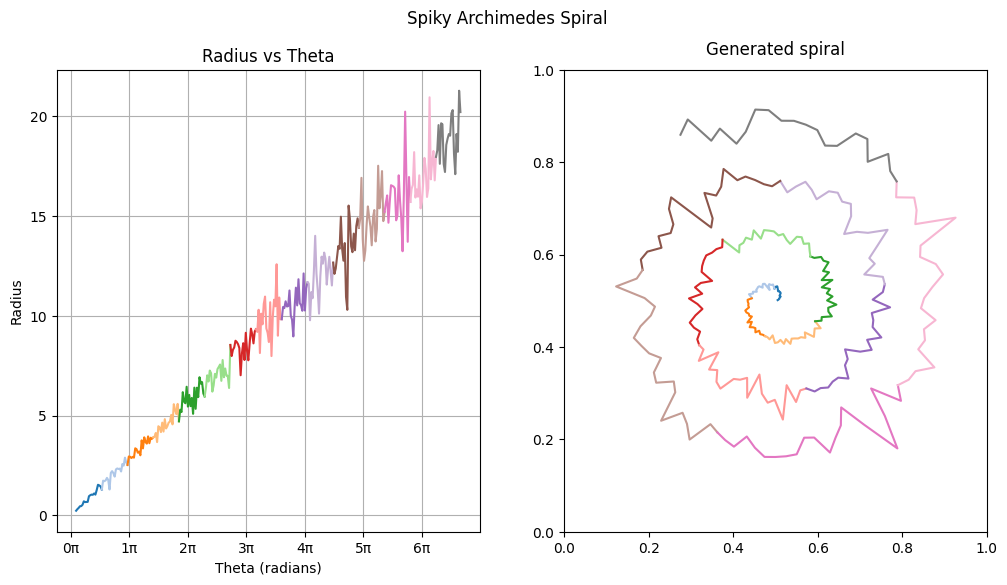

In [949]:
## PARAMETERS
steps_per_rotation = 100
max_theta_range = (6*np.pi, 12*np.pi)
max_theta_offset = np.pi
k_range = (0.5, 2.0)

curved_base_probability = 0.5
sharp_spiky_sigma_range = (0.03, 0.12)
curved_spiky_sigma_range = (0.1, 0.17)
curved_spiky_period_range = (8, 16)

sharp_spiky_smoothing_sigma_range = (0.12, 0.3)
sharp_spiky_smoothing_raduis_range = (1, 2)
curved_spiky_smoothing_sigma_range = (12, 20)
curved_spiky_smoothing_raduis_range = (5, 6)


## TESTING SPIKY ARCHIMEDES SPIRAL GENERATION
# Basic spiral parameters
theta_lb = np.random.uniform(0, max_theta_offset)
theta_ub = np.random.uniform(max_theta_range[0], max_theta_range[1])
theta = np.linspace(theta_lb, theta_ub, int(steps_per_rotation * ((theta_ub-theta_lb) // (2 * np.pi))))
k = np.random.uniform(k_range[0], k_range[1])
r = k * theta

r_spiky = r.copy()
if np.random.rand() < curved_base_probability:
    period = np.random.uniform(curved_spiky_period_range[0], curved_spiky_period_range[1]+1)
    for idx in range(len(r_spiky)):
        scale = np.random.uniform(curved_spiky_sigma_range[0], curved_spiky_sigma_range[1])
        r_spiky[idx] *= np.random.normal(loc=1.0, scale=scale) * np.abs(np.sin(period*theta[idx]))
    sigma = np.random.uniform(curved_spiky_smoothing_sigma_range[0], curved_spiky_smoothing_sigma_range[1])
    radius = np.random.randint(curved_spiky_smoothing_raduis_range[0], curved_spiky_smoothing_raduis_range[1]+1)
    r_spiky = gaussian_filter(r_spiky, sigma=sigma, mode='nearest', radius=radius)

    if np.random.rand() < 0.5:
        for idx in range(len(r_spiky)):
            scale = np.random.uniform(sharp_spiky_sigma_range[0], sharp_spiky_sigma_range[1])
            r_spiky[idx] += np.random.normal(loc=0.0, scale=scale) * r_spiky[idx]
        sigma = np.random.uniform(sharp_spiky_smoothing_sigma_range[0], sharp_spiky_smoothing_sigma_range[1])
        radius = np.random.randint(sharp_spiky_smoothing_raduis_range[0], sharp_spiky_smoothing_raduis_range[1]+1)
        r_spiky = gaussian_filter(r_spiky, sigma=sigma, mode='nearest', radius=radius)
else:
    for idx in range(len(r_spiky)):
        scale = np.random.uniform(sharp_spiky_sigma_range[0], sharp_spiky_sigma_range[1])
        r_spiky[idx] += np.random.normal(loc=0.0, scale=scale) * r_spiky[idx]
    sigma = np.random.uniform(sharp_spiky_smoothing_sigma_range[0], sharp_spiky_smoothing_sigma_range[1])
    radius = np.random.randint(sharp_spiky_smoothing_raduis_range[0], sharp_spiky_smoothing_raduis_range[1]+1)
    r_spiky = gaussian_filter(r_spiky, sigma=sigma, mode='nearest', radius=radius)
    
plot_segmented_spiral(
    gen_theta=theta,
    gen_r=r_spiky,
    num_segments=15,
    num_points=len(theta),
    colors=None,
    figsize=(12, 6),
    plot_title=f"Spiky Archimedes Spiral"
)

**Generation**

In [951]:
N_SAMPLES = 1000
directory = "syn_data/spiky/"
name_template = "spiky_spiral_{}.csv"

sample_idx = 0
while sample_idx < N_SAMPLES:
    theta_lb = np.random.uniform(0, max_theta_offset)
    theta_ub = np.random.uniform(max_theta_range[0], max_theta_range[1])
    theta = np.linspace(theta_lb, theta_ub, int(steps_per_rotation * ((theta_ub-theta_lb) // (2 * np.pi))))
    k = np.random.uniform(k_range[0], k_range[1])
    r = k * theta

    r_spiky = r.copy()
    if np.random.rand() < curved_base_probability:
        period = np.random.uniform(curved_spiky_period_range[0], curved_spiky_period_range[1]+1)
        for idx in range(len(r_spiky)):
            scale = np.random.uniform(curved_spiky_sigma_range[0], curved_spiky_sigma_range[1])
            r_spiky[idx] *= np.random.normal(loc=1.0, scale=scale) * np.abs(np.sin(period*theta[idx]))
        sigma = np.random.uniform(curved_spiky_smoothing_sigma_range[0], curved_spiky_smoothing_sigma_range[1])
        radius = np.random.randint(curved_spiky_smoothing_raduis_range[0], curved_spiky_smoothing_raduis_range[1]+1)
        r_spiky = gaussian_filter(r_spiky, sigma=sigma, mode='nearest', radius=radius)

        if np.random.rand() < 0.5:
            for idx in range(len(r_spiky)):
                scale = np.random.uniform(sharp_spiky_sigma_range[0], sharp_spiky_sigma_range[1])
                r_spiky[idx] += np.random.normal(loc=0.0, scale=scale) * r_spiky[idx]
            sigma = np.random.uniform(sharp_spiky_smoothing_sigma_range[0], sharp_spiky_smoothing_sigma_range[1])
            radius = np.random.randint(sharp_spiky_smoothing_raduis_range[0], sharp_spiky_smoothing_raduis_range[1]+1)
            r_spiky = gaussian_filter(r_spiky, sigma=sigma, mode='nearest', radius=radius)
    else:
        for idx in range(len(r_spiky)):
            scale = np.random.uniform(sharp_spiky_sigma_range[0], sharp_spiky_sigma_range[1])
            r_spiky[idx] += np.random.normal(loc=0.0, scale=scale) * r_spiky[idx]
        sigma = np.random.uniform(sharp_spiky_smoothing_sigma_range[0], sharp_spiky_smoothing_sigma_range[1])
        radius = np.random.randint(sharp_spiky_smoothing_raduis_range[0], sharp_spiky_smoothing_raduis_range[1]+1)
        r_spiky = gaussian_filter(r_spiky, sigma=sigma, mode='nearest', radius=radius)
    
    pd.DataFrame({'theta': theta, 'r': r_spiky}).to_csv(directory + name_template.format(sample_idx), index=False)
    sample_idx += 1

### Plotting the results

In [1032]:
directory = "syn_data/"
sub_directories = ["archimedes/", "flat/", "spiky/", "tight/"]
filenames = ["archimedes_spiral_", "flat_spiral_", "spiky_spiral_", "tight_spiral_"]
num2plot = 2
indices = {
    "archimedes": np.random.randint(0, 1000, size=num2plot),
    "flat": np.random.randint(0, 1000, size=num2plot),
    "spiky": np.random.randint(0, 1000, size=num2plot),
    "tight": np.random.randint(0, 1000, size=num2plot)
}

files = []
for sub_dir, fname in zip(sub_directories, filenames):
    for idx in indices[sub_dir[:-1]]:
        files.append(directory + sub_dir + fname + str(idx) + ".csv")

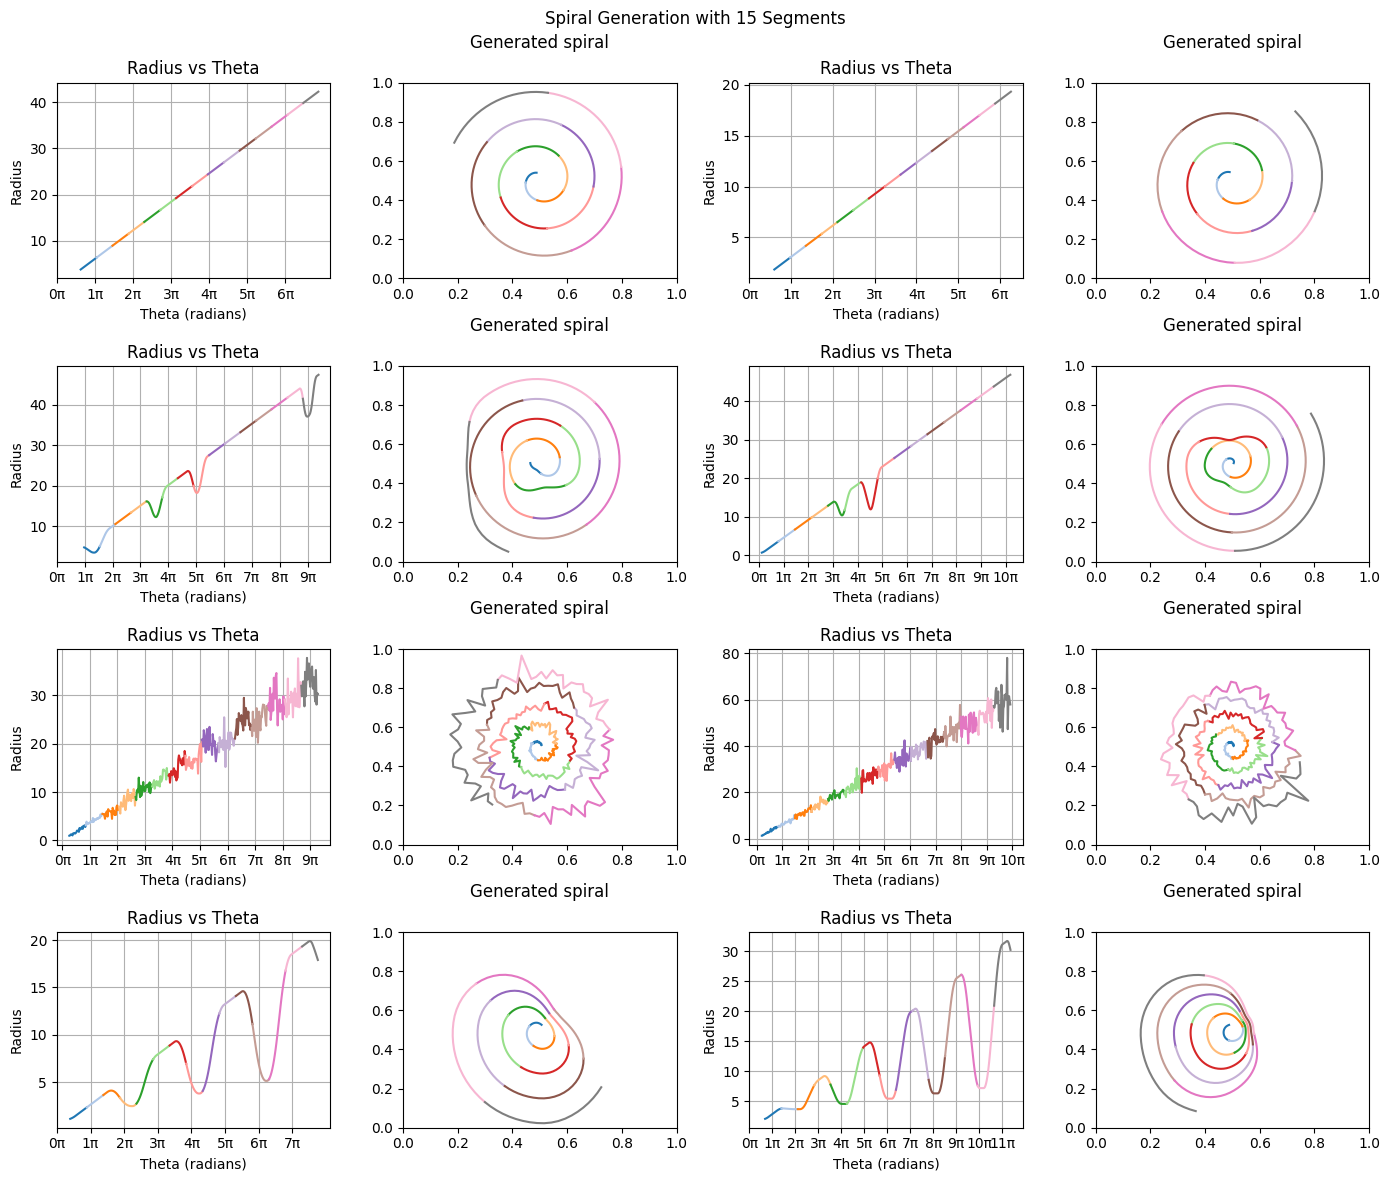

In [1033]:
fig, axs = plt.subplots(4, num2plot*2, figsize=(7*num2plot, 12))
axs = np.array(axs)  # ensure indexing works

for row in range(4):
    for col in range(num2plot):
        filepath = files[row * num2plot + col]
        data = pd.read_csv(filepath)
        theta = data['theta'].values
        r = data['r'].values

        col_ax = col * 2
        ax1 = axs[row, col_ax]  # Cartesian
        ax2 = fig.add_subplot(4, num2plot*2, row*num2plot*2 + col_ax + 2, projection='polar')  # Polar

        plot_segmented_spiral(
            gen_theta=theta,
            gen_r=r,
            num_segments=15,
            num_points=len(theta),
            axes=(ax1, ax2),
        )

plt.tight_layout()
plt.show()

### Addition of x and y coordinates

In [2]:
from pathlib import Path

# === CONFIGURATION ===
parent_dir = Path("./syn_data")
output_dir = parent_dir
output_dir.mkdir(exist_ok=True)

# Loop over all CSVs in all subfolders
for csv_path in parent_dir.glob("*/*.csv"):
    df = pd.read_csv(csv_path)
        
    theta = df['theta'].values
    r = df['r'].values

    # Compute Cartesian coordinates
    df['x'] = r * np.cos(theta)
    df['y'] = r * np.sin(theta)

    # Save result
    # Option A: overwrite
    df.to_csv(csv_path, index=False)

    print(f"Processed: {csv_path.name}")

print("✅ All spirals processed.")

Processed: archimedes_spiral_825.csv
Processed: archimedes_spiral_86.csv
Processed: archimedes_spiral_92.csv
Processed: archimedes_spiral_831.csv
Processed: archimedes_spiral_819.csv
Processed: archimedes_spiral_158.csv
Processed: archimedes_spiral_45.csv
Processed: archimedes_spiral_51.csv
Processed: archimedes_spiral_602.csv
Processed: archimedes_spiral_79.csv
Processed: archimedes_spiral_164.csv
Processed: archimedes_spiral_170.csv
Processed: archimedes_spiral_616.csv
Processed: archimedes_spiral_399.csv
Processed: archimedes_spiral_428.csv
Processed: archimedes_spiral_366.csv
Processed: archimedes_spiral_400.csv
Processed: archimedes_spiral_414.csv
Processed: archimedes_spiral_372.csv
Processed: archimedes_spiral_548.csv
Processed: archimedes_spiral_212.csv
Processed: archimedes_spiral_574.csv
Processed: archimedes_spiral_560.csv
Processed: archimedes_spiral_206.csv
Processed: archimedes_spiral_789.csv
Processed: archimedes_spiral_951.csv
Processed: archimedes_spiral_945.csv
Proces